In [2]:
#importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch

In [3]:
# Reading the CSV file into a pandas DataFrame
df = pd.read_csv("/content/ghc_train.csv")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Filling any missing values in the 'text' column with an empty string
df['text'] = df['text'].fillna('')

y = df['label']
X=df['text']
# Splitting the dataset into training and testing sets
# Using 20% of the data for testing and 80% for training
# Stratifying the split based on the labels to ensure balanced classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel

# Initializing the BERT tokenizer with a pre-trained 'bert-base-uncased' model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Initializing the BERT model with a pre-trained 'bert-base-uncased' model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
# Function to encode text data using a BERT tokenizer
def encode_texts(texts, tokenizer, max_length=100):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )
    return encodings

# Encoding the training and testing text data with a reduced maximum length of 50
X_train_encodings = encode_texts(X_train, tokenizer, max_length=50)  # Reduced max_length
X_test_encodings = encode_texts(X_test, tokenizer, max_length=50)

# Function to get BERT embeddings from encoded text data
def get_bert_embeddings(encodings, bert_model):
    outputs = bert_model(encodings['input_ids'], attention_mask=encodings['attention_mask'])
    return outputs.last_hidden_state

# Setting the batch size for processing
batch_size = 16

In [7]:
# List to store BERT embeddings for the training data
X_train_embeddings = []

# Process the training data in batches to get BERT embeddings
for i in range(0, len(X_train_encodings['input_ids']), batch_size):
    batch_encodings = {key: val[i:i+batch_size] for key, val in X_train_encodings.items()}  # Get a batch of encodings
    batch_embeddings = get_bert_embeddings(batch_encodings, bert_model) # Get BERT embeddings for the batch
    X_train_embeddings.append(batch_embeddings) # Append the batch embeddings to the list

# Concatenate all the batch embeddings into a single tensor
X_train_embeddings = tf.concat(X_train_embeddings, axis=0)

# List to store BERT embeddings for the testing data
X_test_embeddings = []

# Process the testing data in batches to get BERT embeddings
for i in range(0, len(X_test_encodings['input_ids']), batch_size):
    batch_encodings = {key: val[i:i+batch_size] for key, val in X_test_encodings.items()}
    batch_embeddings = get_bert_embeddings(batch_encodings, bert_model)
    X_test_embeddings.append(batch_embeddings)

# Concatenate all the batch embeddings into a single tensor
X_test_embeddings = tf.concat(X_test_embeddings, axis=0)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary format required by TensorFlow
class_weights_dict = dict(enumerate(class_weights))

Epoch 1/5
1102/1102 [==============================] - 434s 384ms/step - loss: 0.5387 - accuracy: 0.7424 - val_loss: 0.5286 - val_accuracy: 0.7706
Epoch 2/5
1102/1102 [==============================] - 430s 390ms/step - loss: 0.4782 - accuracy: 0.7711 - val_loss: 0.4873 - val_accuracy: 0.7532
Epoch 3/5
1102/1102 [==============================] - 432s 392ms/step - loss: 0.4473 - accuracy: 0.7913 - val_loss: 0.6988 - val_accuracy: 0.6422
Epoch 4/5
1102/1102 [==============================] - 433s 393ms/step - loss: 0.4157 - accuracy: 0.8012 - val_loss: 0.6005 - val_accuracy: 0.7824
Epoch 5/5
1102/1102 [==============================] - 434s 394ms/step - loss: 0.3915 - accuracy: 0.8118 - val_loss: 0.3192 - val_accuracy: 0.8539
138/138 - 6s - loss: 0.3192 - accuracy: 0.8539 - 6s/epoch - 42ms/step

Test accuracy: 0.8539019823074341
138/138 [==============================] - 7s 44ms/step


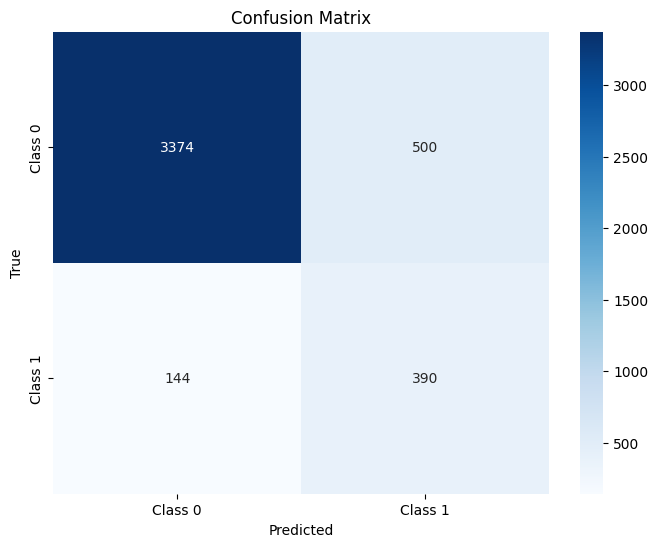

In [8]:

# Define the model
model = Sequential()

# Adding a bidirectional LSTM layer with 256 units, returning sequences, and specifying the input shape
model.add(Bidirectional(LSTM(units=256, return_sequences=True, input_shape=(X_train_embeddings.shape[1], X_train_embeddings.shape[2]))))

# Adding a dropout layer with a rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

# Adding another bidirectional LSTM layer with 64 units, returning sequences
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Adding a dropout layer with a rate of 0.3 to prevent overfitting
model.add(Dropout(0.3))

# Adding another bidirectional LSTM layer with 64 units, not returning sequences
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.2))

# Adding a dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Adding the final dense layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and class weights
history = model.fit(X_train_embeddings, y_train, epochs=5, batch_size=batch_size,
                    validation_data=(X_test_embeddings, y_test),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_embeddings, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Predict the labels for the test set
y_pred = model.predict(X_test_embeddings)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Importing various evaluation metrics from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc

accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred)

# Printing the evaluation metrics
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')

Recall: 0.7303370786516854
ROC AUC Score: 0.8784132283019999


In [10]:
import tensorflow as tf

# Function to predict the label for a given text
def predict_text(text, tokenizer, bert_model, model, max_length=50):
    # Step 1: Encode the text using the BERT tokenizer
    encodings = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )

    # Step 2: Get BERT embeddings for the encoded text
    bert_outputs = bert_model(encodings['input_ids'], attention_mask=encodings['attention_mask'])
    embeddings = bert_outputs.last_hidden_state

    # Pool the outputs: we take the mean of all tokens' embeddings (timesteps)
    pooled_embeddings = tf.reduce_mean(embeddings, axis=1)

    # Reshape pooled embeddings to match LSTM input requirements (batch_size, timesteps, features)
    pooled_embeddings = tf.expand_dims(pooled_embeddings, axis=1)

    # Step 3: Use the trained model to predict the class of the text
    prediction = model.predict(pooled_embeddings)
    predicted_class = (prediction > 0.5).astype("int32")

    return predicted_class

# Example texts to check
example_texts = [
    "Imagine how many famous people may not have existed if abortions had always been so available. ",
    "I hope she gets sodomised by a gang of Somali Street shitters. ",
    "MGTOW is the premise that men should demand unconditional surrender from women, not negotiate with them  "
]

# Predicting the class for each example text
for text in example_texts:
    predicted_class = predict_text([text], tokenizer, bert_model, model)
    if predicted_class == 1:
        print(f"The text: \"{text}\" is hateful.")
    else:
        print(f"The text: \"{text}\" is not hateful.")

1/1 [==============================] - 2s 2s/step
The text: "Imagine how many famous people may not have existed if abortions had always been so available. " is not hateful.
1/1 [==============================] - 0s 84ms/step
The text: "I hope she gets sodomised by a gang of Somali Street shitters. " is hateful.
1/1 [==============================] - 0s 47ms/step
The text: "MGTOW is the premise that men should demand unconditional surrender from women, not negotiate with them  " is hateful.
